*cv_score corrected*

# XGBoost model for Ames

# Contents

[XGBoost](#XGBoost)

[Model Tuning](#Model-Tuning)

[Feature Importances](#Feature-Importances)

[Shap Values](#Shap-Values)

[RFECV](#RFECV)

[Summary](#Summary)

[Resources](#Resources)

In [4]:
#!pip install xgboost

In [5]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb

## Import raw data for reference

In [7]:
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


## Import cleaned data for modeling

**Summary of previous data cleaning:**

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [9]:
ames = pd.read_pickle('ames_clean.pkl')
ames.head(2)

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,126000,30,RL,68.0,7890,Pave,None,Reg,Lvl,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,139500,120,RL,42.0,4235,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,2,2009,WD,Normal


In [10]:
# remove target from dataframe
y = ames['SalePrice']
ames.drop(columns=['SalePrice'], axis=1, inplace=True)
ames.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


In [11]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [12]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [13]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
# extract ordinal_features_list from ordinal_order below
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


OverallQual and OverallCond, while reclassified as object types, are still int types. Convert OverallQual, OverallCond, YrSold, and MoSold from int type to str type for ordinal encoding.

In [15]:
str_OverallQual = ames['OverallQual'].astype(str)
str_OverallCond = ames['OverallCond'].astype(str)
print(type(ames['OverallQual'][0]))
print(type(str_OverallQual[0]))

<class 'int'>
<class 'str'>


In [16]:
ames['OverallCond'] = ames['OverallCond'].astype(str)
ames['OverallQual'] = ames['OverallQual'].astype(str)
ames['MoSold'] = ames['MoSold'].astype(str)
ames['YrSold'] = ames['YrSold'].astype(str)

In [17]:
# define ordering for ordinal features
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    # Overalls here in other notebook
    'OverallQual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'OverallCond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    #
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # Fence quality
    'MoSold': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    'YrSold': ['2006', '2007', '2008', '2009', '2010']
    # 'MoSold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  
    # 'YrSold': [2006, 2007, 2008, 2009, 2010]
}

In [18]:
# get list of ordinal features that syncs with ordinal dictionary 
ordinal_features_list = list(ordinal_order.keys())
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [19]:
# stack features for processing: numerical + nominal + ordinal
X = ames[numerical_features_list].join(ames[nominal_features_list])
X = X.join(ames[ordinal_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


# XGBoost

[Contents](#Contents)

**Method:**

1. Prepare data for modeling
- numerical features: no scaling
- categorical features: enable native handling
    - define categorical dtypes as 'category' and
    - set enable_categorical=True

2. Get a base model: evaluate model on full dataset and default parameters using cross validation
   
3. Tune hyperparameters with GridSearchCV 
- fit grid object to full dataset and retrieve cv score for full dataset (X and y). This is the score that will be used to evaluate the model and compare to other models. 
- fit grid object to train and test data to examine train-test gap for overfitting.

4. Choose best optimized model (based on highest cv score)

# 1. Prepare data

In [23]:
ames.select_dtypes(include=['object'])

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,30,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,120,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,TA,TA,Y,None,None,None,2,2009,WD,Normal
2,30,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,TA,Po,N,None,None,None,11,2007,WD,Normal
3,70,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,...,TA,TA,N,None,None,None,5,2009,WD,Normal
4,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,TA,TA,Y,None,None,None,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,30,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,Fa,Po,P,None,None,None,5,2009,WD,Normal
2576,20,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,...,TA,TA,Y,None,None,None,6,2009,WD,Normal
2577,90,RH,Pave,None,Reg,HLS,AllPub,Inside,Gtl,Crawfor,...,TA,TA,Y,None,None,None,8,2007,WD,Normal
2578,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,None,None,None,7,2007,WD,Normal


In [24]:
ames_categories = ames.select_dtypes(include=['object']).columns.to_list()
ames.select_dtypes(include=['object']).columns.to_list()

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [25]:
categories = ordinal_features_list+nominal_features_list
ordinal_features_list+nominal_features_list

['Electrical',
 'LotShape',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MoSold',
 'YrSold',
 'MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [26]:
are_same = set(ames_categories) == set(categories)
print(are_same)

True


**sanity check:** all the ordinal and nominal categories I was expecting are object types in ames.

In [28]:
ames.columns

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [29]:
# make a copy 
xgb_ames = ames.copy()

In [30]:
# change 'object' dtypes to 'category' dtypes
for col in xgb_ames.select_dtypes(include=['object']).columns:
    xgb_ames[col] = xgb_ames[col].astype('category')

In [31]:
xgb_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GrLivArea      2580 non-null   int64   
 1   MSSubClass     2580 non-null   category
 2   MSZoning       2580 non-null   category
 3   LotFrontage    2580 non-null   float64 
 4   LotArea        2580 non-null   int64   
 5   Street         2580 non-null   category
 6   Alley          2580 non-null   category
 7   LotShape       2580 non-null   category
 8   LandContour    2580 non-null   category
 9   Utilities      2580 non-null   category
 10  LotConfig      2580 non-null   category
 11  LandSlope      2580 non-null   category
 12  Neighborhood   2580 non-null   category
 13  Condition1     2580 non-null   category
 14  Condition2     2580 non-null   category
 15  BldgType       2580 non-null   category
 16  HouseStyle     2580 non-null   category
 17  OverallQual    2580 non-null   ca

In [32]:
y

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2580, dtype: int64

In [33]:
# Define features with modified data types 
X = xgb_ames
X.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


# 2. Base Model
Evaluate model on full dataset and default params using cross-validation

In [35]:
# Initialize XGBoost regressor with native handling for categorical data
xgb_model = xgb.XGBRegressor(
    seed=42,
    enable_categorical=True
)

In [36]:
# create storage for tuning results
tuning_results = {}

In [37]:
# Perform 5-fold cross-validation
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'xgb base model mean cv score with manually imputed data:', round(mean_score_base_model, 4))

# split data, to look at model fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

#retrain model on train-test data 
xgb_model.fit(X_train, y_train)
train_score = xgb_model.score(X_train, y_train)
test_score = xgb_model.score(X_test, y_test)
diff = train_score - test_score
print(f'XGBoost base_model train score:', round(train_score, 4))
print(f'XGBoost base_model test score:', round(test_score, 4))
print(f'base model train-test gap:', round(diff, 4))

# store results
tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

cv scores: [0.82785956 0.9066564  0.91237372 0.91832043 0.89515852]
xgb base model mean cv score with manually imputed data: 0.8921
XGBoost base_model train score: 0.9996
XGBoost base_model test score: 0.9012
base model train-test gap: 0.0984


### Compare manually imputed data score with natively imputed data score. 
Look how the model handles raw_data without imputation.

In [39]:
xgb_raw_ames = ames_raw.copy()
xgb_raw_ames.drop(columns=['PID', 'SalePrice'], inplace=True)
xgb_raw_ames

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,1001,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,1039,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,AllPub,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,1665,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,...,40,0,NaN,NaN,NaN,0,5,2009,WD,Normal
2576,1733,20,RL,NaN,13680,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
2577,2002,90,RH,82.0,6270,Pave,NaN,Reg,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
2578,1842,60,RL,NaN,8826,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal


In [40]:
xgb_raw_ames.isnull().sum().sum()

13813

In [41]:
xgb_raw_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   MSSubClass     2580 non-null   int64  
 2   MSZoning       2580 non-null   object 
 3   LotFrontage    2118 non-null   float64
 4   LotArea        2580 non-null   int64  
 5   Street         2580 non-null   object 
 6   Alley          168 non-null    object 
 7   LotShape       2580 non-null   object 
 8   LandContour    2580 non-null   object 
 9   Utilities      2580 non-null   object 
 10  LotConfig      2580 non-null   object 
 11  LandSlope      2580 non-null   object 
 12  Neighborhood   2580 non-null   object 
 13  Condition1     2580 non-null   object 
 14  Condition2     2580 non-null   object 
 15  BldgType       2580 non-null   object 
 16  HouseStyle     2580 non-null   object 
 17  OverallQual    2580 non-null   int64  
 18  OverallC

In [42]:
# change 'object' dtypes to 'category' dtypes
for col in xgb_raw_ames.select_dtypes(include=['object']).columns:
    xgb_raw_ames[col] = xgb_raw_ames[col].astype('category')

In [43]:
xgb_raw_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GrLivArea      2580 non-null   int64   
 1   MSSubClass     2580 non-null   int64   
 2   MSZoning       2580 non-null   category
 3   LotFrontage    2118 non-null   float64 
 4   LotArea        2580 non-null   int64   
 5   Street         2580 non-null   category
 6   Alley          168 non-null    category
 7   LotShape       2580 non-null   category
 8   LandContour    2580 non-null   category
 9   Utilities      2580 non-null   category
 10  LotConfig      2580 non-null   category
 11  LandSlope      2580 non-null   category
 12  Neighborhood   2580 non-null   category
 13  Condition1     2580 non-null   category
 14  Condition2     2580 non-null   category
 15  BldgType       2580 non-null   category
 16  HouseStyle     2580 non-null   category
 17  OverallQual    2580 non-null   in

### Change OverallCond, OverallQual, MSSubClass, MoSold, YrSold to 'category' dtypes
to be consistent with data cleaning across other models. 

These features were determined to be categorical through my EDA, and should also be marked as 'category' types, not 'integer' types. 

In [45]:
# make a list of features to change 
int_to_cat_cols = ['OverallCond', 'OverallQual', 'MSSubClass', 'MoSold', 'YrSold']
xgb_raw_ames[int_to_cat_cols] = xgb_raw_ames[int_to_cat_cols].astype('category')

In [46]:
xgb_raw_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GrLivArea      2580 non-null   int64   
 1   MSSubClass     2580 non-null   category
 2   MSZoning       2580 non-null   category
 3   LotFrontage    2118 non-null   float64 
 4   LotArea        2580 non-null   int64   
 5   Street         2580 non-null   category
 6   Alley          168 non-null    category
 7   LotShape       2580 non-null   category
 8   LandContour    2580 non-null   category
 9   Utilities      2580 non-null   category
 10  LotConfig      2580 non-null   category
 11  LandSlope      2580 non-null   category
 12  Neighborhood   2580 non-null   category
 13  Condition1     2580 non-null   category
 14  Condition2     2580 non-null   category
 15  BldgType       2580 non-null   category
 16  HouseStyle     2580 non-null   category
 17  OverallQual    2580 non-null   ca

In [47]:
X_raw = xgb_raw_ames
X_raw.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [48]:
y

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2580, dtype: int64

In [49]:
# Initialize XGBoost regressor with native handling for categorical data
xgb_model = xgb.XGBRegressor(
    seed=42,
    enable_categorical=True
)

In [50]:
# train model on full data set
xgb_model.fit(X_raw, y)

# Perform 5-fold cross-validation
raw_scores = cross_val_score(xgb_model, X_raw, y, cv=5, scoring='r2')

# Calculate the average R-squared score
mean_score_raw = raw_scores.mean()

print(f'mean xgb score with manually imputed data:', round(mean_score_base_model, 4))
print(f'mean xgb score with raw data (imputed natively):', round(mean_score_raw, 4))

# split raw data, to look at model fit
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state = 0)

#retrain model on train-test data 
xgb_model.fit(X_train, y_train)
train_score_raw = xgb_model.score(X_train, y_train)
test_score_raw = xgb_model.score(X_test, y_test)
diff_raw = train_score_raw - test_score_raw
print(f'XGBoost base_model, native handling train score:', round(train_score_raw, 4))
print(f'XGBoost base_model, native handling test score:', round(test_score_raw, 4))
print(f'base model train-test gap:', round(diff_raw, 4))

# store results
tuning_results['Model _0_raw'] = {
    'mean-cv on X and y': round(mean_score_raw, 4),
    'train score': round(train_score_raw, 4),
    'test score': round(test_score_raw, 4),
    'train-test gap': round(diff_raw, 4)                   
}

mean xgb score with manually imputed data: 0.8921
mean xgb score with raw data (imputed natively): 0.9025
XGBoost base_model, native handling train score: 0.9997
XGBoost base_model, native handling test score: 0.8951
base model train-test gap: 0.1046


In [51]:
# re-split data on X, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# 3. Model Tuning

[Contents](#Contents)

Tune model on train-test data using cross validation (via GridSearchCV)
- Evaluate model on cv score from best_score_ and best_estimator_
- Examine train_test gap for best_estimator
- Choose best optimized model (highest cv score)

In [53]:
# Define parameter grid for XGBoost
xgb_params_1 = {
    'n_estimators': [200, 300, 500, 800],       
    'learning_rate': [0.01, 0.05, 0.1],        
    'max_depth': [2, 3, 4],                      
    'reg_lambda': [1, 3, 5, 10]             
}

# Initialize XGBoost model
xgb_model_1 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_1 = GridSearchCV(
    xgb_model_1, 
    xgb_params_1, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_1.fit(X, y)
xgb_best_model_1 = xgb_grid_1.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_1.best_params_
full_cv = round(xgb_grid_1.best_score_, 4)
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_1.fit(X_train, y_train)
best_train_model = xgb_grid_1.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _1'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 144 candidates, totalling 720 fits
MODEL _1:
Evaluate model on full dataset:
model parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800, 'reg_lambda': 3}
mean cv score on full dataset: 0.9294
-----------
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Check for overfitting on train-test data:
train score: 0.9984
test score: 0.9261
train-test gap: 0.0722


In [54]:
# Define parameter grid for XGBoost
xgb_params_1 = {
    'n_estimators': [200, 300, 500, 800],       
    'learning_rate': [0.01, 0.05, 0.1],        
    'max_depth': [2, 3, 4],                      
    'reg_lambda': [1, 3, 5, 10]             
}

# Initialize XGBoost model
xgb_model_1 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_1 = GridSearchCV(
    xgb_model_1, 
    xgb_params_1, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_1.fit(X, y)
xgb_best_model_1 = xgb_grid_1.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_1.best_params_
full_cv = round(xgb_grid_1.best_score_, 4)
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_1.fit(X_train, y_train)
best_train_model = xgb_grid_1.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _1'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 144 candidates, totalling 720 fits
MODEL _1:
Evaluate model on full dataset:
model parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 800, 'reg_lambda': 3}
mean cv score on full dataset: 0.9294
-----------
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Check for overfitting on train-test data:
train score: 0.9984
test score: 0.9261
train-test gap: 0.0722


In [55]:
# Define parameter grid for XGBoost
xgb_params_2 = {
    'n_estimators': [500, 800],         
    'learning_rate': [0.01, 0.05],   # lower learning rate     
    'max_depth': [2, 3],             # shallower trees         
    'reg_lambda': [5, 10, 15, 20]    # higher regularization   
}

# Initialize XGBoost model
xgb_model_2 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_2 = GridSearchCV(
    xgb_model_2, 
    xgb_params_2, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_2.fit(X, y)
xgb_best_model_2 = xgb_grid_2.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_2.best_params_
full_cv = round(xgb_grid_2.best_score_, 4)
print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_2.fit(X_train, y_train)
best_train_model = xgb_grid_2.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _2'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 32 candidates, totalling 160 fits
MODEL _2:
Evaluate model on full dataset:
model parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 800, 'reg_lambda': 15}
mean cv score on full dataset: 0.9304
-----------
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Check for overfitting on train-test data:
train score: 0.9808
test score: 0.9354
train-test gap: 0.0454


In [56]:
# Define parameter grid for XGBoost
xgb_params_3 = {
    'n_estimators': [800, 1000],
    'learning_rate': [0.03, 0.05],            
    'max_depth': [2, 3],                        # shallower trees
    'reg_lambda': [15, 20, 25],                 # more regularization?
    'subsample': [0.8, 0.9]                     # add some sampling  
}

# Initialize XGBoost model
xgb_model_3 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_3 = GridSearchCV(
    xgb_model_3, 
    xgb_params_3, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_3.fit(X, y)
xgb_best_model_3 = xgb_grid_3.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_3.best_params_
full_cv = round(xgb_grid_3.best_score_, 4)
print('MODEL _3:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_3.fit(X_train, y_train)
best_train_model = xgb_grid_3.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _3'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
MODEL _3:
Evaluate model on full dataset:
model parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'reg_lambda': 15, 'subsample': 0.8}
mean cv score on full dataset: 0.9318
-----------
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Check for overfitting on train-test data:
train score: 0.9891
test score: 0.9371
train-test gap: 0.052


In [57]:
# Define parameter grid for XGBoost, on 1 parameter
xgb_params_4 = {
    'learning_rate': [0.06, 0.08, 0.1],     
}

# Initialize XGBoost model
xgb_model_4 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_4 = GridSearchCV(
    xgb_model_4, 
    xgb_params_4, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_4.fit(X, y)
xgb_best_model_4 = xgb_grid_4.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_4.best_params_
full_cv = round(xgb_grid_4.best_score_, 4)
print('MODEL _4:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_4.fit(X_train, y_train)
best_train_model = xgb_grid_4.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _4'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 3 candidates, totalling 15 fits
MODEL _4:
Evaluate model on full dataset:
model parameters: {'learning_rate': 0.1}
mean cv score on full dataset: 0.9042
-----------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Check for overfitting on train-test data:
train score: 0.9953
test score: 0.9118
train-test gap: 0.0834


### More targeted approach:
Start by tuning max_depth and min_child_weight, then look more closely at other parameters below.

In [59]:
# Define parameter grid for XGBoost, on 2 parameters
xgb_params_5 = {
    'min_child_weight': [2,3,4],
    'max_depth': [3, 4, 5]    
}

# Initialize XGBoost model
xgb_model_5 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_5 = GridSearchCV(
    xgb_model_5, 
    xgb_params_5, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_5.fit(X, y)
xgb_best_model_5 = xgb_grid_5.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_5.best_params_
full_cv = round(xgb_grid_5.best_score_, 4)
print('MODEL _5:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_5.fit(X_train, y_train)
best_train_model = xgb_grid_5.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _5'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 9 candidates, totalling 45 fits
MODEL _5:
Evaluate model on full dataset:
model parameters: {'max_depth': 3, 'min_child_weight': 2}
mean cv score on full dataset: 0.9174
-----------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Check for overfitting on train-test data:
train score: 0.983
test score: 0.9328
train-test gap: 0.0502


### Set these parameters within the model and then tune additional parameters, setting them as we go:

Change one at a time.
- gamma: The model chooses default of gamma = 0.
- regularization: alpha --> settling around 10200 (without lambda)
- learning rate: reduce the learning rate

In [61]:
# Define parameter grid for XGBoost, on 2 parameters
xgb_params_6 = {
    # 'gamma': [0,1,2,3,4],
    # 'reg_lambda': [46, 47, 48]
    # 'reg_alpha': [10000, 10100, 10200],
    'learning_rate': [0.25, 0.3, 0.35]    
}

# Initialize XGBoost model
xgb_model_6 = xgb.XGBRegressor(
    random_state=42,
    enable_categorical=True,
    tree_method='hist'  # faster for categorical data
)

# Grid search
xgb_grid_6 = GridSearchCV(
    xgb_model_6, 
    xgb_params_6, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
xgb_grid_6.fit(X, y)
xgb_best_model_6 = xgb_grid_6.best_estimator_

# evaluate on full dataset, X and y
model_params = xgb_grid_6.best_params_
full_cv = round(xgb_grid_6.best_score_, 4)
print('MODEL _6:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
xgb_grid_6.fit(X_train, y_train)
best_train_model = xgb_grid_6.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _6'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 3 candidates, totalling 15 fits
MODEL _6:
Evaluate model on full dataset:
model parameters: {'learning_rate': 0.35}
mean cv score on full dataset: 0.8973
-----------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Check for overfitting on train-test data:
train score: 0.9991
test score: 0.899
train-test gap: 0.1001


In [62]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _3,0.9318,0.9891,0.9371,0.0520
Model _2,0.9304,0.9808,0.9354,0.0454
Model _1,0.9294,0.9984,0.9261,0.0722
Model _5,0.9174,0.9830,0.9328,0.0502
Model _4,0.9042,0.9953,0.9118,0.0834
Model _0_raw,0.9025,0.9997,0.8951,0.1046
Model _6,0.8973,0.9991,0.8990,0.1001
Model _0,0.8921,0.9996,0.9012,0.0984


# 4. Best Model 
Choose best optimized model based on highest cv score fit to full dataset

In [64]:
xgb_grid_3.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_lambda': 15,
 'subsample': 0.8}

# Feature Importances

[Contents](#Contents)

Look at most important features for optimized model, built on full dataset

In [66]:
# Initialize XGBoost regressor 
final_model = xgb.XGBRegressor(
    learning_rate = 0.05, 
    max_depth = 3, 
    n_estimators = 1000, 
    reg_lambda = 15, 
    subsample = 0.8,
    seed=42,
    enable_categorical=True
)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [67]:
# Get feature importances from XGBoost
importances = final_model.feature_importances_

# Get feature names 
feature_names = X.columns

# Create the DataFrame
feature_importances_df = pd.DataFrame(
    importances, 
    index=feature_names, 
    columns=['Importance']
).sort_values('Importance', ascending=False)

In [68]:
feature_importances_df

,Importance
OverallQual,0.236903
GarageCars,0.169511
KitchenQual,0.060281
GrLivArea,0.057164
BsmtQual,0.056234
...,...
MiscVal,0.000132
Street,0.000000
MiscFeature,0.000000
Utilities,0.000000


gain is a measure of how much a feature, used to split a tree, improves the objective function (reduces loss)


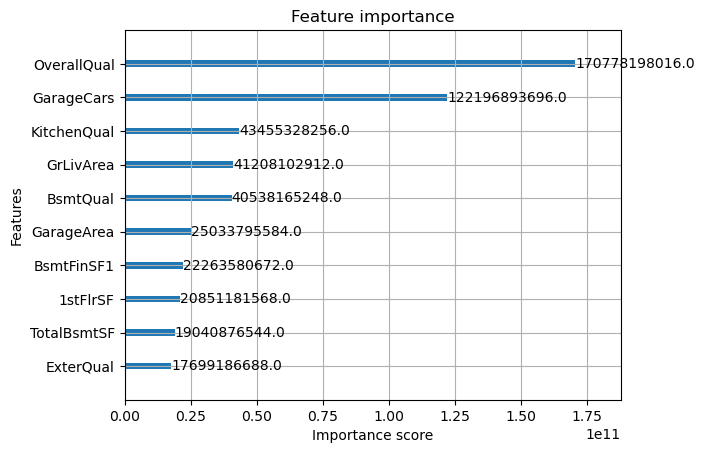

In [69]:
# Built-in feature importance plot
xgb.plot_importance(final_model, max_num_features=10, importance_type='gain')
# xgb.plot_importance(xgb_best_model_3, max_num_features=10, importance_type='gain')
print(f'gain is a measure of how much a feature, used to split a tree, improves the objective function (reduces loss)')
plt.show()

gain is a measure of how much a feature, used to split a tree, improves the objective function (reduces loss)


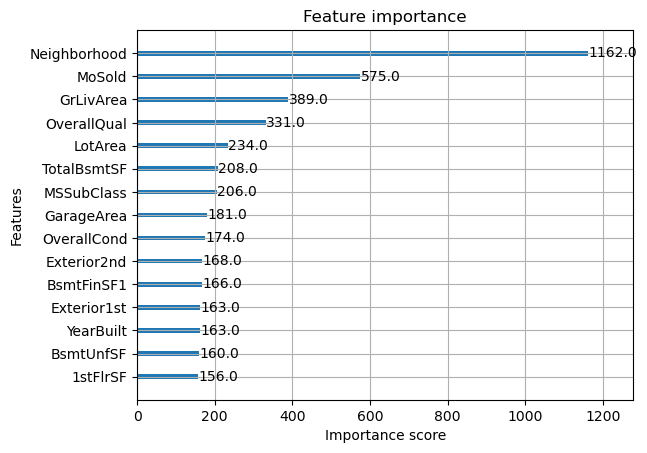

In [70]:
# Built-in feature importance plot
#xgb.plot_importance(xgb_best_model_3, max_num_features=15, importance_type='weight')
xgb.plot_importance(final_model, max_num_features=15, importance_type='weight')
print(f'gain is a measure of how much a feature, used to split a tree, improves the objective function (reduces loss)')
plt.show()

# SHAP Values 

[Contents](#Contents)

Use model trained on split data for SHAP analysis

In [72]:
import shap

In [73]:
# Initialize optimized XGBoost regressor
final_model = xgb.XGBRegressor(
    learning_rate = 0.05, 
    max_depth = 3, 
    n_estimators = 1000, 
    reg_lambda = 15, 
    subsample = 0.8,
    seed=42,
    enable_categorical=True
)

# train model
final_model.fit(X_train, y_train)

print(f"Model trained on {X_train.shape[0]} houses with {X_train.shape[1]} features")

Model trained on 2064 houses with 79 features


In [74]:
print(f'model baseline: $',round(y.mean(),2))

model baseline: $ 178059.62


Use **TreeExplainer** for tree-based models.

In [76]:
# evaluate on optimized model: xgb_best_model
explainer = shap.TreeExplainer(final_model)

In [77]:
# From Vinod's article
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test)

print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): ${explainer.expected_value:,.2f}")
 
# Quick verification: SHAP values should be additive
sample_idx = 0
model_pred = final_model.predict(X_test.iloc[[sample_idx]])[0]
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: ${model_pred:,.2f}")
print(f"Verification - SHAP sum: ${shap_sum:,.2f} (difference: {abs(model_pred - shap_sum):.2f})")                                    

Calculating SHAP values...
SHAP values calculated for 516 predictions
Each prediction explained by 79 features
Model's base prediction (expected value): $177,329.14
Verification - Model prediction: $146,923.59
Verification - SHAP sum: $146,923.48 (difference: 0.11)


## Local feature insights
Looking at individual houses

In [79]:
print(f'SalePrice:', y_test.iloc[0])
X_test.iloc[0]

SalePrice: 142100


GrLivArea          1053
MSSubClass           20
MSZoning             RL
LotFrontage        60.0
LotArea            8250
                  ...  
MiscVal               0
MoSold                7
YrSold             2007
SaleType            WD 
SaleCondition    Normal
Name: 953, Length: 79, dtype: object

Analyzing prediction for house index 0:
Predicted price: $146,923.59
Actual price: $142,100.00
Prediction error: $4,823.59


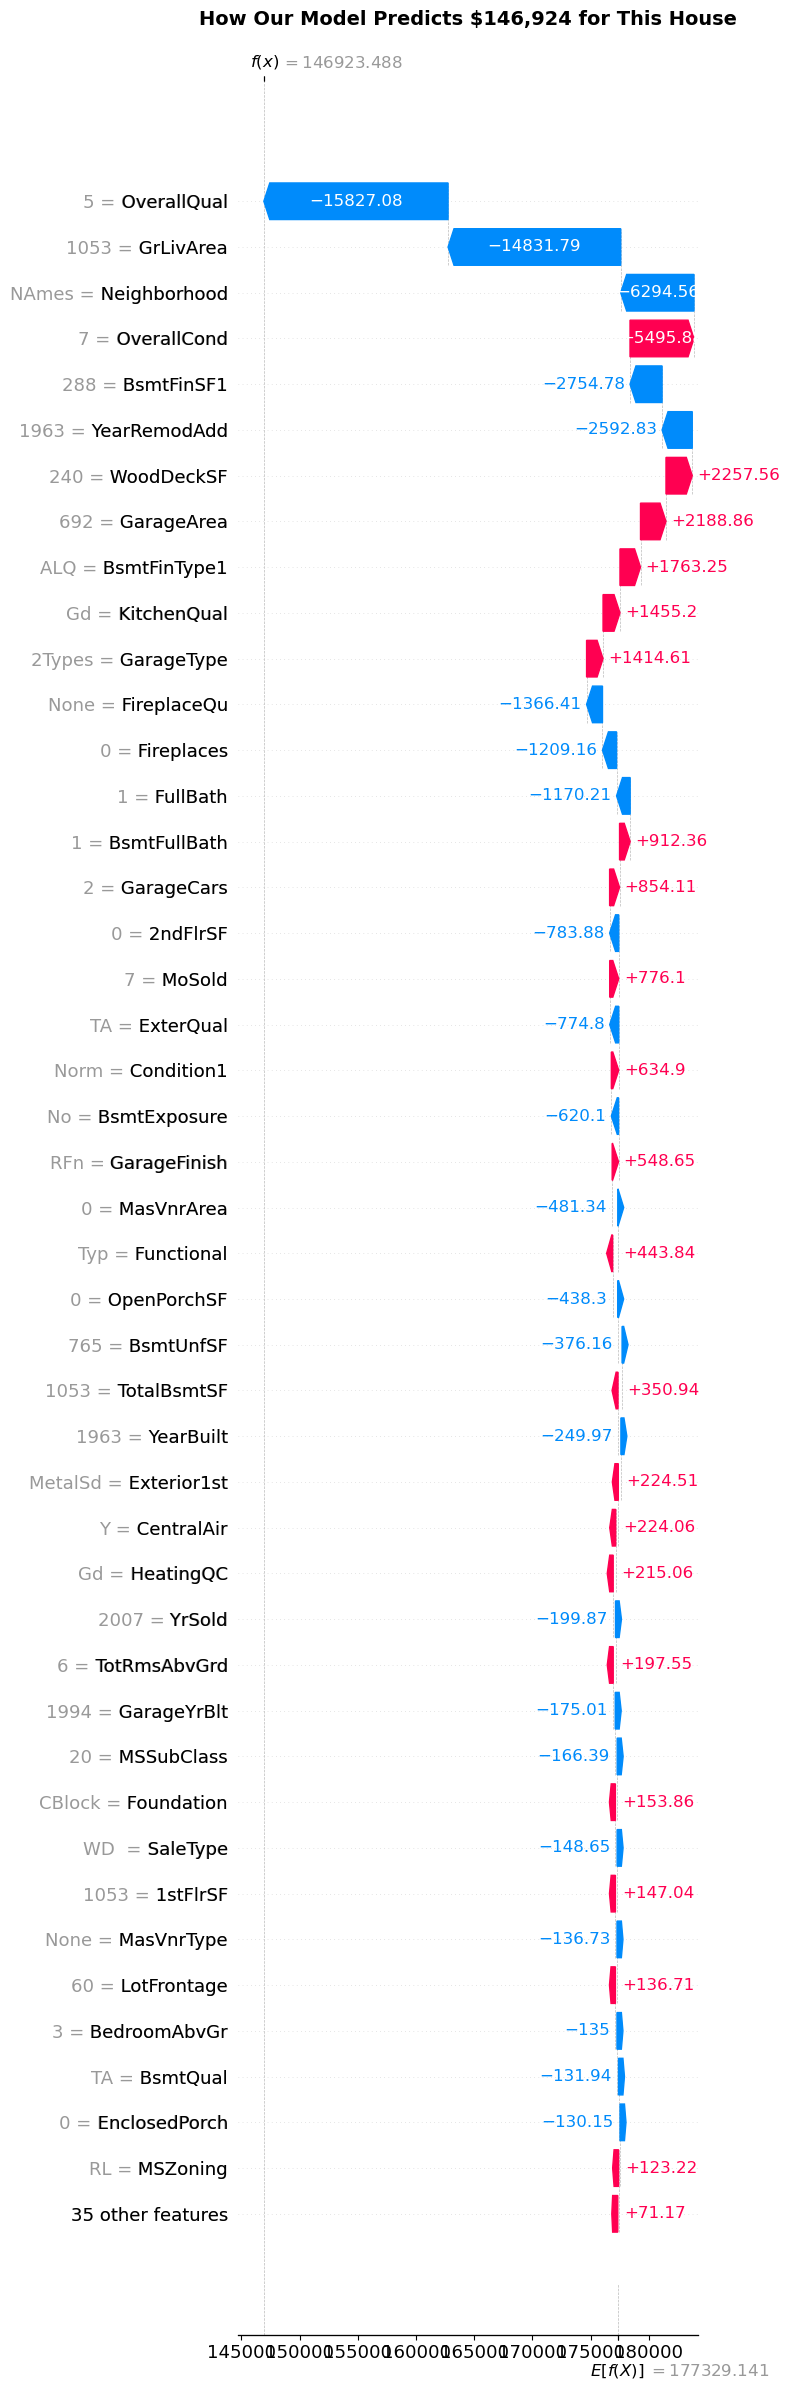

In [80]:
# Select an interesting prediction to explain
sample_idx = 0  # You can change this to explore different houses
sample_prediction = final_model.predict(X_test.iloc[[sample_idx]])[0]
actual_price = y_test.iloc[sample_idx]
 
print(f"Analyzing prediction for house index {sample_idx}:")
print(f"Predicted price: ${sample_prediction:,.2f}")
print(f"Actual price: ${actual_price:,.2f}")
print(f"Prediction error: ${abs(sample_prediction - actual_price):,.2f}")
 
# Create SHAP waterfall plot
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx], 
        base_values=explainer.expected_value, 
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns.tolist()
    ),
    max_display=45,  # Show top contributing features
    show=False
)
plt.title(f'How Our Model Predicts ${sample_prediction:,.0f} for This House', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [81]:
# Analyze the feature contributions for our sample house
feature_values = X_test.iloc[sample_idx]
shap_contributions = shap_values[sample_idx]

# Create a detailed breakdown of contributions
feature_breakdown = pd.DataFrame({
    'Feature': X_test.columns,
    'Feature_Value': feature_values.values,
    'SHAP_Contribution': shap_contributions,
    'Impact': ['Increases Price' if x > 0 else 'Decreases Price' for x in shap_contributions]
}).sort_values('SHAP_Contribution', key=abs, ascending=False)

print("Top 10 Feature Contributions to This Prediction:")
print("=" * 60)
for idx, row in feature_breakdown.head(10).iterrows():
    impact_symbol = "↑" if row['SHAP_Contribution'] > 0 else "↓"
    if isinstance(row['Feature_Value'], (int, float)):
        value_str = f"{row['Feature_Value']:.1f}"
    else:
        value_str = str(row['Feature_Value'])

    print(f"{row['Feature']:20} {impact_symbol} ${row['SHAP_Contribution']:8,.0f} "
      f"(Value: {value_str})")

print(f"\nBase prediction: ${explainer.expected_value:,.2f}")
print(f"Sum of contributions: ${shap_contributions.sum():+,.2f}")
print(f"Final prediction: ${explainer.expected_value + shap_contributions.sum():,.2f}")

Top 10 Feature Contributions to This Prediction:
OverallQual          ↓ $ -15,827 (Value: 5)
GrLivArea            ↓ $ -14,832 (Value: 1053)
Neighborhood         ↓ $  -6,295 (Value: NAmes)
OverallCond          ↑ $   5,496 (Value: 7)
BsmtFinSF1           ↓ $  -2,755 (Value: 288.0)
YearRemodAdd         ↓ $  -2,593 (Value: 1963)
WoodDeckSF           ↑ $   2,258 (Value: 240)
GarageArea           ↑ $   2,189 (Value: 692.0)
BsmtFinType1         ↑ $   1,763 (Value: ALQ)
KitchenQual          ↑ $   1,455 (Value: Gd)

Base prediction: $177,329.14
Sum of contributions: $-30,405.65
Final prediction: $146,923.48


## **Diversion:** 
compare with Vinod's example

In [83]:
# Convert to numpy array and find where condition is True
indices = np.where(y_train == 166000)[0]
print(indices)

[ 537 1184 1811 1941 1954]


In [84]:
print(y_train.iloc[1811])
X_train.iloc[1811]

166000


GrLivArea          1190
MSSubClass           20
MSZoning             RL
LotFrontage        58.0
LotArea            7250
                  ...  
MiscVal               0
MoSold               11
YrSold             2009
SaleType            WD 
SaleCondition    Normal
Name: 809, Length: 79, dtype: object

### Vinod's example house is at index 1811 in my **training** dataset

In [86]:
# From Vinod's article
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_train)

print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): ${explainer.expected_value:,.2f}")
 
# Quick verification: SHAP values should be additive
sample_idx = 0
model_pred = final_model.predict(X_train.iloc[[sample_idx]])[0]
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: ${model_pred:,.2f}")
print(f"Verification - SHAP sum: ${shap_sum:,.2f} (difference: {abs(model_pred - shap_sum):.2f})")                                    

Calculating SHAP values...
SHAP values calculated for 2064 predictions
Each prediction explained by 79 features
Model's base prediction (expected value): $177,329.14
Verification - Model prediction: $161,280.16
Verification - SHAP sum: $161,280.22 (difference: 0.06)


Analyzing prediction for house index 1811:
Predicted price: $146,923.59
Actual price: $166,000.00
Prediction error: $19,076.41


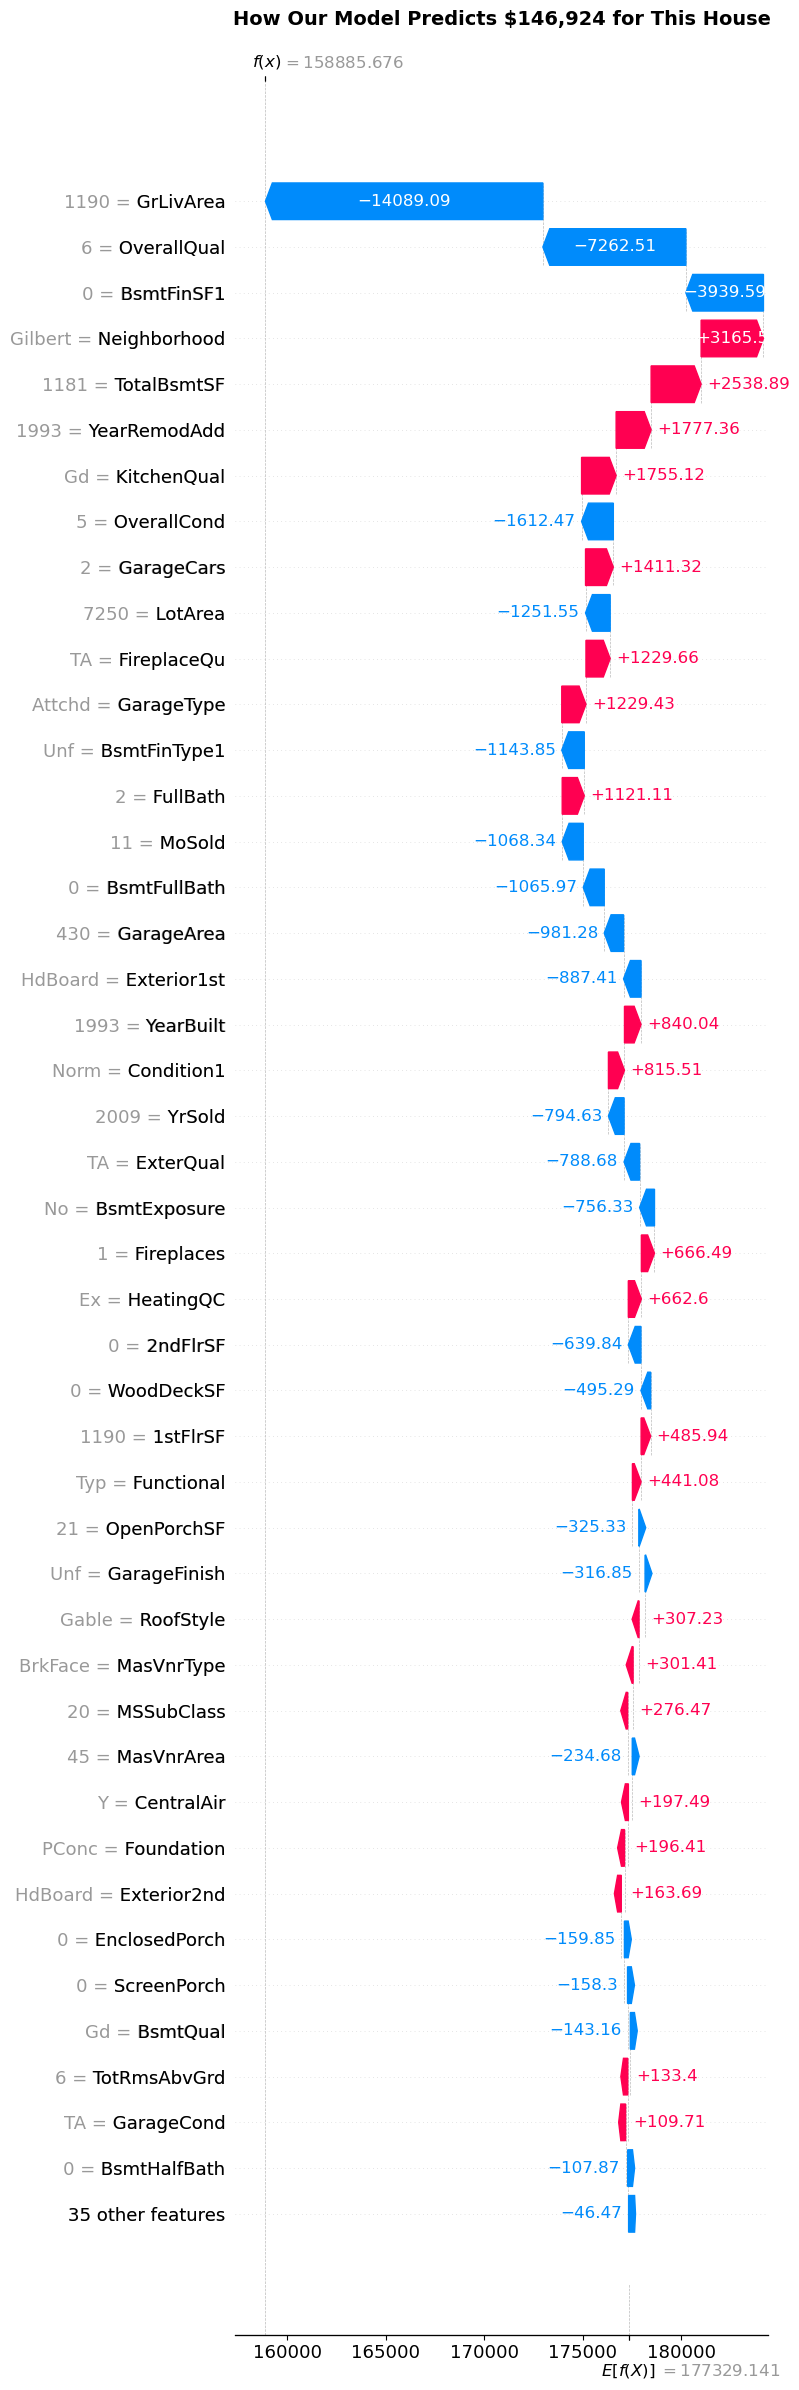

In [87]:
# Select an interesting prediction to explain
sample_idx = 1811  # You can change this to explore different houses
# sample_prediction = final_model.predict(X_train.iloc[[sample_idx]])[0]
actual_price = y_train.iloc[sample_idx]
 
print(f"Analyzing prediction for house index {sample_idx}:")
print(f"Predicted price: ${sample_prediction:,.2f}")
print(f"Actual price: ${actual_price:,.2f}")
print(f"Prediction error: ${abs(sample_prediction - actual_price):,.2f}")
 
# Create SHAP waterfall plot
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx], 
        base_values=explainer.expected_value, 
        data=X_train.iloc[sample_idx],
        feature_names=X_train.columns.tolist()
    ),
    max_display=45,  # Show top contributing features
    show=False
)
plt.title(f'How Our Model Predicts ${sample_prediction:,.0f} for This House', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Back to anlysis
re-evaluate SHAP explainer on test data

In [89]:
# From Vinod's article
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test)

print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): ${explainer.expected_value:,.2f}")
 
# Quick verification: SHAP values should be additive
sample_idx = 0
model_pred = final_model.predict(X_test.iloc[[sample_idx]])[0]
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: ${model_pred:,.2f}")
print(f"Verification - SHAP sum: ${shap_sum:,.2f} (difference: {abs(model_pred - shap_sum):.2f})")                                    

Calculating SHAP values...
SHAP values calculated for 516 predictions
Each prediction explained by 79 features
Model's base prediction (expected value): $177,329.14
Verification - Model prediction: $146,923.59
Verification - SHAP sum: $146,923.48 (difference: 0.11)


Analyzing prediction for house index 0:
Predicted price: $146,923.59
Actual price: $142,100.00
Prediction error: $4,823.59


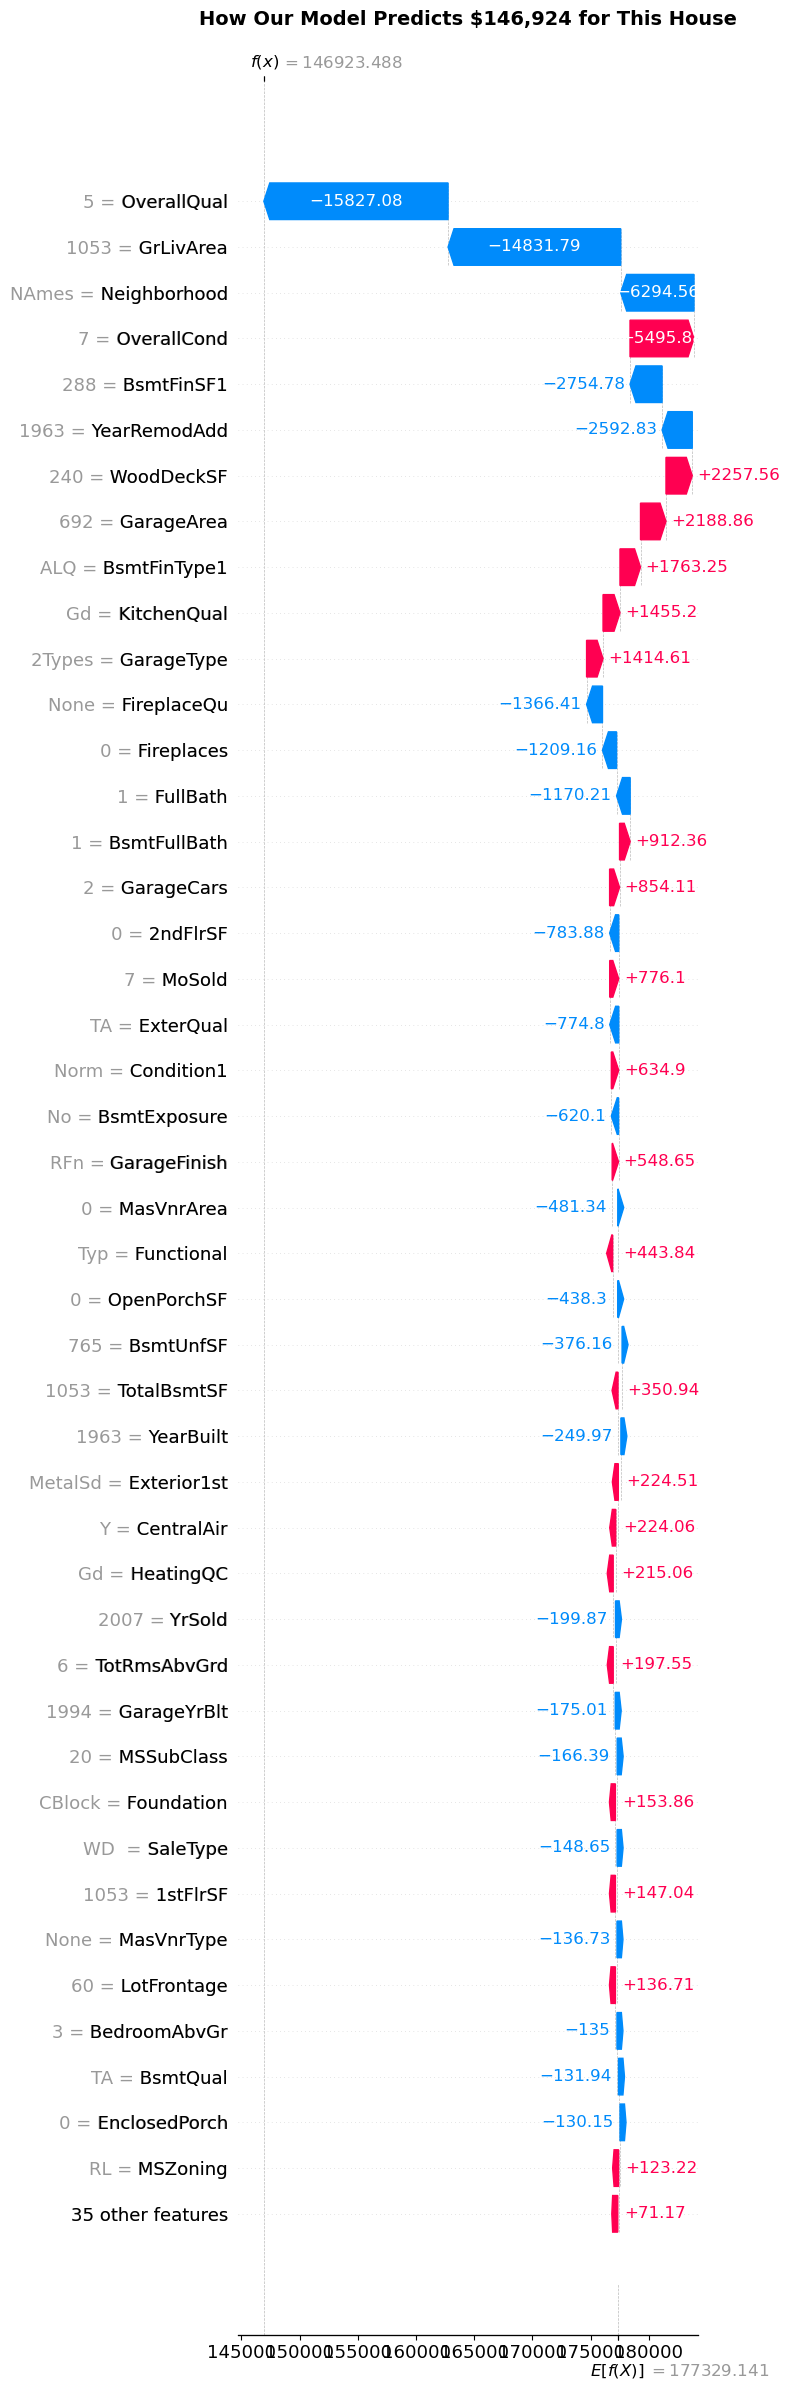

In [90]:
# Select an interesting prediction to explain
sample_idx = 0  # You can change this to explore different houses
sample_prediction = final_model.predict(X_test.iloc[[sample_idx]])[0]
actual_price = y_test.iloc[sample_idx]
 
print(f"Analyzing prediction for house index {sample_idx}:")
print(f"Predicted price: ${sample_prediction:,.2f}")
print(f"Actual price: ${actual_price:,.2f}")
print(f"Prediction error: ${abs(sample_prediction - actual_price):,.2f}")
 
# Create SHAP waterfall plot
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx], 
        base_values=explainer.expected_value, 
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns.tolist()
    ),
    max_display=45,  # Show top contributing features
    show=False
)
plt.title(f'How Our Model Predicts ${sample_prediction:,.0f} for This House', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [91]:
# Analyze the feature contributions for our sample house
feature_values = X_test.iloc[sample_idx]
shap_contributions = shap_values[sample_idx]

# Create a detailed breakdown of contributions
feature_breakdown = pd.DataFrame({
    'Feature': X_test.columns,
    'Feature_Value': feature_values.values,
    'SHAP_Contribution': shap_contributions,
    'Impact': ['Increases Price' if x > 0 else 'Decreases Price' for x in shap_contributions]
}).sort_values('SHAP_Contribution', key=abs, ascending=False)

print("Top 10 Feature Contributions to This Prediction:")
print("=" * 60)
for idx, row in feature_breakdown.head(10).iterrows():
    impact_symbol = "↑" if row['SHAP_Contribution'] > 0 else "↓"
    if isinstance(row['Feature_Value'], (int, float)):
        value_str = f"{row['Feature_Value']:.1f}"
    else:
        value_str = str(row['Feature_Value'])

    print(f"{row['Feature']:20} {impact_symbol} ${row['SHAP_Contribution']:8,.0f} "
      f"(Value: {value_str})")

print(f"\nBase prediction: ${explainer.expected_value:,.2f}")
print(f"Sum of contributions: ${shap_contributions.sum():+,.2f}")
print(f"Final prediction: ${explainer.expected_value + shap_contributions.sum():,.2f}")

Top 10 Feature Contributions to This Prediction:
OverallQual          ↓ $ -15,827 (Value: 5)
GrLivArea            ↓ $ -14,832 (Value: 1053)
Neighborhood         ↓ $  -6,295 (Value: NAmes)
OverallCond          ↑ $   5,496 (Value: 7)
BsmtFinSF1           ↓ $  -2,755 (Value: 288.0)
YearRemodAdd         ↓ $  -2,593 (Value: 1963)
WoodDeckSF           ↑ $   2,258 (Value: 240)
GarageArea           ↑ $   2,189 (Value: 692.0)
BsmtFinType1         ↑ $   1,763 (Value: ALQ)
KitchenQual          ↑ $   1,455 (Value: Gd)

Base prediction: $177,329.14
Sum of contributions: $-30,405.65
Final prediction: $146,923.48


## Global feature insights

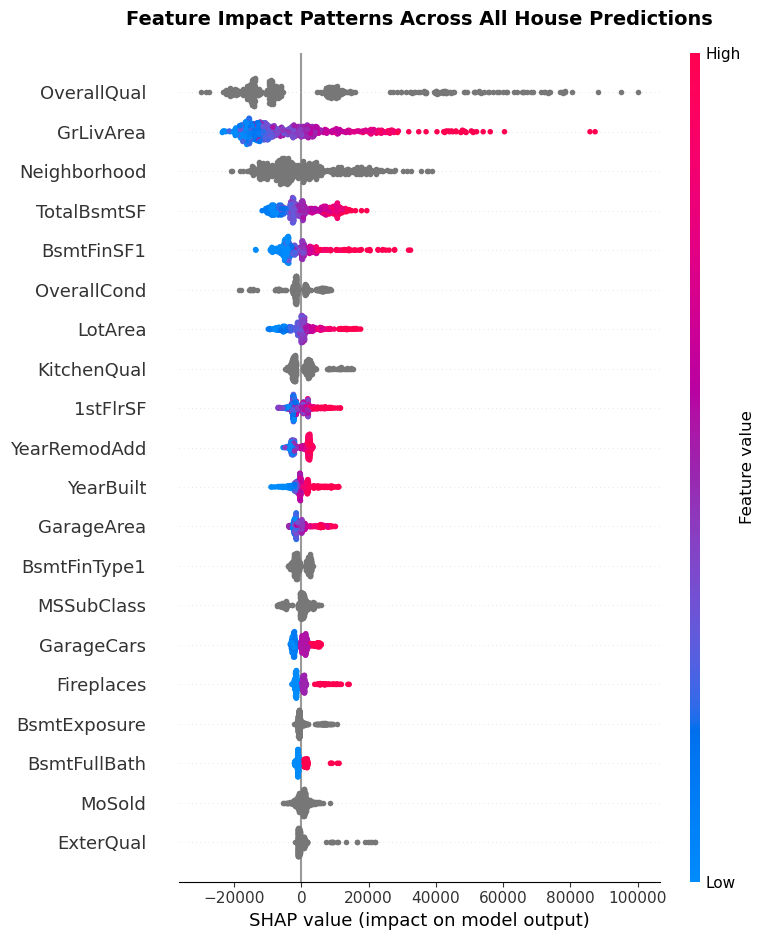

In [93]:
# Create SHAP summary plot to understand global feature patterns
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=X_test.columns.tolist(),
    max_display=20,  # Show top 20 most important features
    show=False
)
plt.title('Feature Impact Patterns Across All House Predictions', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Compare SHAP Values and feature_importances
**Note:** Because I am evaluating my SHAP values on a model trained on unseen data (X_test), I also need to consider feature_importances trained on this same data, not the full dataset (X, y) as was done above. This allows for a fair comparison between the two, but means the feature_importances here will differ from the feature importances in the above section, pulled from a model trained on the full dataset. *(i.e., cannot compare ranking in table below with feature_importances_df)*

In [95]:
# Compare SHAP importance with traditional feature importance
print("Feature Importance Comparison:")
print("-" * 50)

# SHAP-based importance (mean absolute SHAP values)
shap_importance = np.mean(np.abs(shap_values), axis=0)
shap_ranking = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

# Traditional XGBoost feature importance
xgb_importance = final_model.feature_importances_
xgb_ranking = pd.DataFrame({
    'Feature': X_test.columns,
    'XGBoost_Importance': xgb_importance
}).sort_values('XGBoost_Importance', ascending=False)

print("Top 10 Most Important Features (SHAP vs XGBoost):")
print("SHAP Ranking\t\t\tXGBoost Ranking")
print("-" * 60)
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    xgb_feat = xgb_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {xgb_feat}")

print(f"\nKey Insights:")
print(f"Most impactful feature: {shap_ranking.iloc[0]['Feature']}")
print(f"Average SHAP impact per feature: ${np.mean(shap_importance):,.0f}")

Feature Importance Comparison:
--------------------------------------------------
Top 10 Most Important Features (SHAP vs XGBoost):
SHAP Ranking			XGBoost Ranking
------------------------------------------------------------
 1. OverallQual    		 1. OverallQual
 2. GrLivArea      		 2. GarageCars
 3. Neighborhood   		 3. ExterQual
 4. TotalBsmtSF    		 4. KitchenQual
 5. BsmtFinSF1     		 5. GrLivArea
 6. OverallCond    		 6. Fireplaces
 7. LotArea        		 7. BsmtFinSF1
 8. KitchenQual    		 8. 1stFlrSF
 9. 1stFlrSF       		 9. GarageType
10. YearRemodAdd   		10. BsmtQual

Key Insights:
Most impactful feature: OverallQual
Average SHAP impact per feature: $1,267


In [96]:
# feature importances for model trained on all the data, X,y
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,Importance
OverallQual,0.236903
GarageCars,0.169511
KitchenQual,0.060281
GrLivArea,0.057164
BsmtQual,0.056234
GarageArea,0.034727
BsmtFinSF1,0.030884
1stFlrSF,0.028925
TotalBsmtSF,0.026413
ExterQual,0.024552


## Understanding the differences:

**feature_importances_:**

measures how often each feature is used to split nodes across all the trees in the ensemble. The more frequently a feature is used, the higher its importance. 

**Limitations:** 
- Does not account for how much each split improves the model.
- Can favor features that have more split points (continuous features).
- Does not account for feature interactions.
- Less reliable for understanding true feature impact.

**SHAP values with TreeExplainer:**

measures the average marginal contribution of each feature on individual predictions by calculating how much each feature pushes the prediction away from the baseline.

**Advantages:**
- Considers interactions between features.
- Better interpretability.
- Provides local and global analysis (per house and per feature).

# Summary

[Contents](#Contents)

### Model scores and train-test gaps:

In [100]:
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _3,0.9318,0.9891,0.9371,0.0520
Model _2,0.9304,0.9808,0.9354,0.0454
Model _1,0.9294,0.9984,0.9261,0.0722
Model _5,0.9174,0.9830,0.9328,0.0502
Model _4,0.9042,0.9953,0.9118,0.0834
Model _0_raw,0.9025,0.9997,0.8951,0.1046
Model _6,0.8973,0.9991,0.8990,0.1001
Model _0,0.8921,0.9996,0.9012,0.0984


### Best model hyperparameters:

In [102]:
xgb_grid_3.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_lambda': 15,
 'subsample': 0.8}

### Top 10 feature importances:
on full dataset

In [104]:
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,Importance
OverallQual,0.236903
GarageCars,0.169511
KitchenQual,0.060281
GrLivArea,0.057164
BsmtQual,0.056234
GarageArea,0.034727
BsmtFinSF1,0.030884
1stFlrSF,0.028925
TotalBsmtSF,0.026413
ExterQual,0.024552


### SHAP Analysis:
on train-test split data

In [106]:
print("Top 10 Most Important Features (SHAP vs XGBoost):")
print("SHAP Ranking\t\t\tXGBoost Ranking")
print("-" * 60)
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    xgb_feat = xgb_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {xgb_feat}")

Top 10 Most Important Features (SHAP vs XGBoost):
SHAP Ranking			XGBoost Ranking
------------------------------------------------------------
 1. OverallQual    		 1. OverallQual
 2. GrLivArea      		 2. GarageCars
 3. Neighborhood   		 3. ExterQual
 4. TotalBsmtSF    		 4. KitchenQual
 5. BsmtFinSF1     		 5. GrLivArea
 6. OverallCond    		 6. Fireplaces
 7. LotArea        		 7. BsmtFinSF1
 8. KitchenQual    		 8. 1stFlrSF
 9. 1stFlrSF       		 9. GarageType
10. YearRemodAdd   		10. BsmtQual


In [293]:
# save data for model comparisons
xgb_models = tuning_results_df.copy()
xgb_models['algorithm'] = 'XGBoost'

In [295]:
xgb_models

,mean-cv on X and y,train score,test score,train-test gap,algorithm
Model _0,0.8921,0.9996,0.9012,0.0984,XGBoost
Model _0_raw,0.9025,0.9997,0.8951,0.1046,XGBoost
Model _1,0.9294,0.9984,0.9261,0.0722,XGBoost
Model _2,0.9304,0.9808,0.9354,0.0454,XGBoost
Model _3,0.9318,0.9891,0.9371,0.0520,XGBoost
Model _4,0.9042,0.9953,0.9118,0.0834,XGBoost
Model _5,0.9174,0.9830,0.9328,0.0502,XGBoost
Model _6,0.8973,0.9991,0.8990,0.1001,XGBoost


In [299]:
xgb_models.index.name = 'model'
xgb_models = xgb_models.reset_index()

In [301]:
xgb_models

,model,mean-cv on X and y,train score,test score,train-test gap,algorithm
0,Model _0,0.8921,0.9996,0.9012,0.0984,XGBoost
1,Model _0_raw,0.9025,0.9997,0.8951,0.1046,XGBoost
2,Model _1,0.9294,0.9984,0.9261,0.0722,XGBoost
3,Model _2,0.9304,0.9808,0.9354,0.0454,XGBoost
4,Model _3,0.9318,0.9891,0.9371,0.0520,XGBoost
5,Model _4,0.9042,0.9953,0.9118,0.0834,XGBoost
6,Model _5,0.9174,0.9830,0.9328,0.0502,XGBoost
7,Model _6,0.8973,0.9991,0.8990,0.1001,XGBoost


In [303]:
xgb_models.to_csv('xgboost_models.csv')

# Resources

[Contents](#Contents)

[A Gentle Introduction to SHAP for Tree-Based Models](https://machinelearningmastery.com/a-gentle-introduction-to-shap-for-tree-based-models/)

[Navigating Missing Data Challenges With XGBoost](https://machinelearningmastery.com/navigating-missing-data-challenges-with-xgboost/) RFECV

# Extra
[Contents](#Contents)

# RFECV 

[Contents](#Contents)

recursive feature elimination with cross validation

*from Vinod's post*

In [ ]:
# from sklearn.feature_selection import RFECV

# # Convert all object-type features to categorical and then to codes
# rfecv_cat_features = ames.select_dtypes(include=['object']).columns
# for col in rfecv_cat_features:
#     ames[col] = ames[col].astype('category').cat.codes

# X.info()

# X = ames.copy()
# X.head(2)

# y

# # Initialize XGBoost regressor
# rfecv_model = xgb.XGBRegressor(seed=42, enable_categorical=True)

# # Initialize RFECV
# rfecv = RFECV(estimator=rfecv_model, step=1, cv=5,
#               scoring='r2', min_features_to_select=1)

# # Fit RFECV
# rfecv.fit(X, y)

# # Print the optimal number of features and their names
# print("Optimal number of features: ", rfecv.n_features_)
# print("Best features: ", X.columns[rfecv.support_])

# rfecv.support_

# X.iloc[:, rfecv.support_]

# # Build on the block of code above
# # Cross-validate the final model using only the selected features
# final_model = xgb.XGBRegressor(seed=42, enable_categorical=True)
# cv_scores = cross_val_score(final_model, X.iloc[:, rfecv.support_], y, cv=5, scoring='r2')
 
# # Calculate the average R-squared score
# mean_r2 = cv_scores.mean()
 
# print(f"Average Cross-validated R² score with selected features: {mean_r2:.4f}")

# # This is 0.36% better.

In [ ]:
# # Built-in feature importance plot
# xgb.plot_importance(xgb_best_model, max_num_features=15, importance_type='weight')
# print(f'weight is a measure of how often a feature is used in trees')
# plt.show()

# # Built-in feature importance plot
# xgb.plot_importance(xgb_best_model_4, max_num_features=15, importance_type='weight')
# print(f'weight is a measure of how often a feature is used in trees')
# plt.show()

# # Built-in feature importance plot
# xgb.plot_importance(xgb_best_model, max_num_features=15, importance_type='gain')
# print(f'gain is a measure of how much a feature, used to split a tree, improves the objective function (reduces loss)')
# plt.show()

# # Built-in feature importance plot
# xgb.plot_importance(xgb_best_model_4, max_num_features=15, importance_type='gain')
# print(f'gain is a measure of how much a feature, used to split a tree, improves the objective function (reduces loss)')
# plt.show()

# # Built-in feature importance plot
# xgb.plot_importance(xgb_best_model, max_num_features=15, importance_type='cover')
# plt.show()

# # Built-in feature importance plot
# xgb.plot_importance(xgb_best_model_4, max_num_features=15, importance_type='cover')
# plt.show()

# SHAP 

In [131]:
# !pip install shap
# pip install --upgrade ipywidgets jupyter

In [132]:
# import shap

In [133]:
# y.mean()

In [134]:
# # evaluate on optimized mode: xgb_best_model
# explainer = shap.TreeExplainer(xgb_best_model)

In [135]:
# # From Vinod's article
# print("Calculating SHAP values...")
# shap_values = explainer.shap_values(X_test)

# print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
# print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# # The base value (expected value) - what the model predicts on "average"
# print(f"Model's base prediction (expected value): ${explainer.expected_value:,.2f}")
 
# # Quick verification: SHAP values should be additive
# sample_idx = 0
# model_pred = xgb_best_model.predict(X_test.iloc[[sample_idx]])[0]
# shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
# print(f"Verification - Model prediction: ${model_pred:,.2f}")
# print(f"Verification - SHAP sum: ${shap_sum:,.2f} (difference: {abs(model_pred - shap_sum):.2f})")                                    

In [136]:
# X_test.iloc[0]

In [137]:
# y_test.iloc[0]

In [138]:
# # Select an interesting prediction to explain
# sample_idx = 0  # You can change this to explore different houses
# sample_prediction = xgb_best_model.predict(X_test.iloc[[sample_idx]])[0]
# actual_price = y_test.iloc[sample_idx]
 
# print(f"Analyzing prediction for house index {sample_idx}:")
# print(f"Predicted price: ${sample_prediction:,.2f}")
# print(f"Actual price: ${actual_price:,.2f}")
# print(f"Prediction error: ${abs(sample_prediction - actual_price):,.2f}")
 
# # Create SHAP waterfall plot
# plt.figure(figsize=(12, 8))
# shap.waterfall_plot(
#     shap.Explanation(
#         values=shap_values[sample_idx], 
#         base_values=explainer.expected_value, 
#         data=X_test.iloc[sample_idx],
#         feature_names=X_test.columns.tolist()
#     ),
#     max_display=45,  # Show top contributing features
#     show=False
# )
# plt.title(f'How Our Model Predicts ${sample_prediction:,.0f} for This House', 
#           fontsize=14, fontweight='bold', pad=20)
# plt.tight_layout()
# plt.show()

In [139]:
# # Analyze the feature contributions for our sample house
# feature_values = X_test.iloc[sample_idx]
# shap_contributions = shap_values[sample_idx]

# # Create a detailed breakdown of contributions
# feature_breakdown = pd.DataFrame({
#     'Feature': X_test.columns,
#     'Feature_Value': feature_values.values,
#     'SHAP_Contribution': shap_contributions,
#     'Impact': ['Increases Price' if x > 0 else 'Decreases Price' for x in shap_contributions]
# }).sort_values('SHAP_Contribution', key=abs, ascending=False)

# print("Top 10 Feature Contributions to This Prediction:")
# print("=" * 60)
# for idx, row in feature_breakdown.head(10).iterrows():
#     impact_symbol = "↑" if row['SHAP_Contribution'] > 0 else "↓"
#     if isinstance(row['Feature_Value'], (int, float)):
#         value_str = f"{row['Feature_Value']:.1f}"
#     else:
#         value_str = str(row['Feature_Value'])

#     print(f"{row['Feature']:20} {impact_symbol} ${row['SHAP_Contribution']:8,.0f} "
#       f"(Value: {value_str})")

# print(f"\nBase prediction: ${explainer.expected_value:,.2f}")
# print(f"Sum of contributions: ${shap_contributions.sum():+,.2f}")
# print(f"Final prediction: ${explainer.expected_value + shap_contributions.sum():,.2f}")

In [140]:
# y_test.iloc[3]

In [141]:
X_test.iloc[3]

GrLivArea           1468
MSSubClass            20
MSZoning              RL
LotFrontage         74.0
LotArea             9612
                  ...   
MiscVal                0
MoSold                12
YrSold              2009
SaleType             New
SaleCondition    Partial
Name: 302, Length: 79, dtype: object

In [142]:
# # Select an interesting prediction to explain
# sample_idx = 3  # You can change this to explore different houses
# sample_prediction = xgb_best_model.predict(X_test.iloc[[sample_idx]])[0]
# actual_price = y_test.iloc[sample_idx]
 
# print(f"Analyzing prediction for house index {sample_idx}:")
# print(f"Predicted price: ${sample_prediction:,.2f}")
# print(f"Actual price: ${actual_price:,.2f}")
# print(f"Prediction error: ${abs(sample_prediction - actual_price):,.2f}")
 
# # Create SHAP waterfall plot
# plt.figure(figsize=(12, 8))
# shap.waterfall_plot(
#     shap.Explanation(
#         values=shap_values[sample_idx], 
#         base_values=explainer.expected_value, 
#         data=X_test.iloc[sample_idx],
#         feature_names=X_test.columns.tolist()
#     ),
#     max_display=45,  # Show top contributing features
#     show=False
# )
# plt.title(f'How Our Model Predicts ${sample_prediction:,.0f} for This House', 
#           fontsize=14, fontweight='bold', pad=20)
# plt.tight_layout()
# plt.show()

In [143]:
# # Analyze the feature contributions for our sample house
# feature_values = X_test.iloc[sample_idx]
# shap_contributions = shap_values[sample_idx]

# # Create a detailed breakdown of contributions
# feature_breakdown = pd.DataFrame({
#     'Feature': X_test.columns,
#     'Feature_Value': feature_values.values,
#     'SHAP_Contribution': shap_contributions,
#     'Impact': ['Increases Price' if x > 0 else 'Decreases Price' for x in shap_contributions]
# }).sort_values('SHAP_Contribution', key=abs, ascending=False)

# print("Top 10 Feature Contributions to This Prediction:")
# print("=" * 60)
# for idx, row in feature_breakdown.head(10).iterrows():
#     impact_symbol = "↑" if row['SHAP_Contribution'] > 0 else "↓"
#     if isinstance(row['Feature_Value'], (int, float)):
#         value_str = f"{row['Feature_Value']:.1f}"
#     else:
#         value_str = str(row['Feature_Value'])

#     print(f"{row['Feature']:20} {impact_symbol} ${row['SHAP_Contribution']:8,.0f} "
#       f"(Value: {value_str})")

# print(f"\nBase prediction: ${explainer.expected_value:,.2f}")
# print(f"Sum of contributions: ${shap_contributions.sum():+,.2f}")
# print(f"Final prediction: ${explainer.expected_value + shap_contributions.sum():,.2f}")